In [1]:
import matplotlib.pyplot as plt

import astroalign as aa
from astropy.io import fits

import numpy as np

import matplotlib.colors as colors



In [2]:
with fits.open('/home/kevin/Documents/M8data/M8/no_bias/SUPA01564806.fits') as f:
    img_hdr = f[0].header.copy()
    img_data = f[0].data.copy()
    #img_data = img_data.byteswap().newbyteorder()
    #take out the overscan
    #img_data = remove_oscan(img_hdr, img_data)
with fits.open('/home/kevin/Documents/M8data/M8/false_image/SUPA01564806.fits') as f:
    false_hdr = f[0].header.copy()
    false_data = f[0].data.copy()

img_data = img_data.astype(float)
false_data = false_data.byteswap(inplace=True).newbyteorder()

In [3]:
with fits.open('/home/kevin/Documents/M8data/M8/no_bias/SUPA01564816.fits') as f:
    img_hdr1 = f[0].header.copy()
    img_data1 = f[0].data.copy()
    #img_data = img_data.byteswap().newbyteorder()
    #take out the overscan
    #img_data = remove_oscan(img_hdr, img_data)
with fits.open('/home/kevin/Documents/M8data/M8/false_image/SUPA01564816.fits') as f:
    false_hdr1 = f[0].header.copy()
    false_data1 = f[0].data.copy()

img_data1 = img_data1.astype(float)
false_data1 = false_data1.byteswap(inplace=True).newbyteorder()

In [4]:
import sep
sep.set_extract_pixstack(5000000)
sep.get_extract_pixstack()

5000000

In [5]:
sep.get_sub_object_limit()

1024

In [6]:
# img_ma = np.ma.masked_array(img_data, mask = img_data < 3000)
# img_ma_norm = (img_ma - img_ma.mean())/img_ma.std()
# false_data_norm = (false_data-false_data.mean())/false_data.std()

registered_image, footprint = aa.register(img_data1, img_data, fill_value=np.nan)

In [7]:
import sys
sys.path.append('../src')
import sep
from convenience_functions import show_image

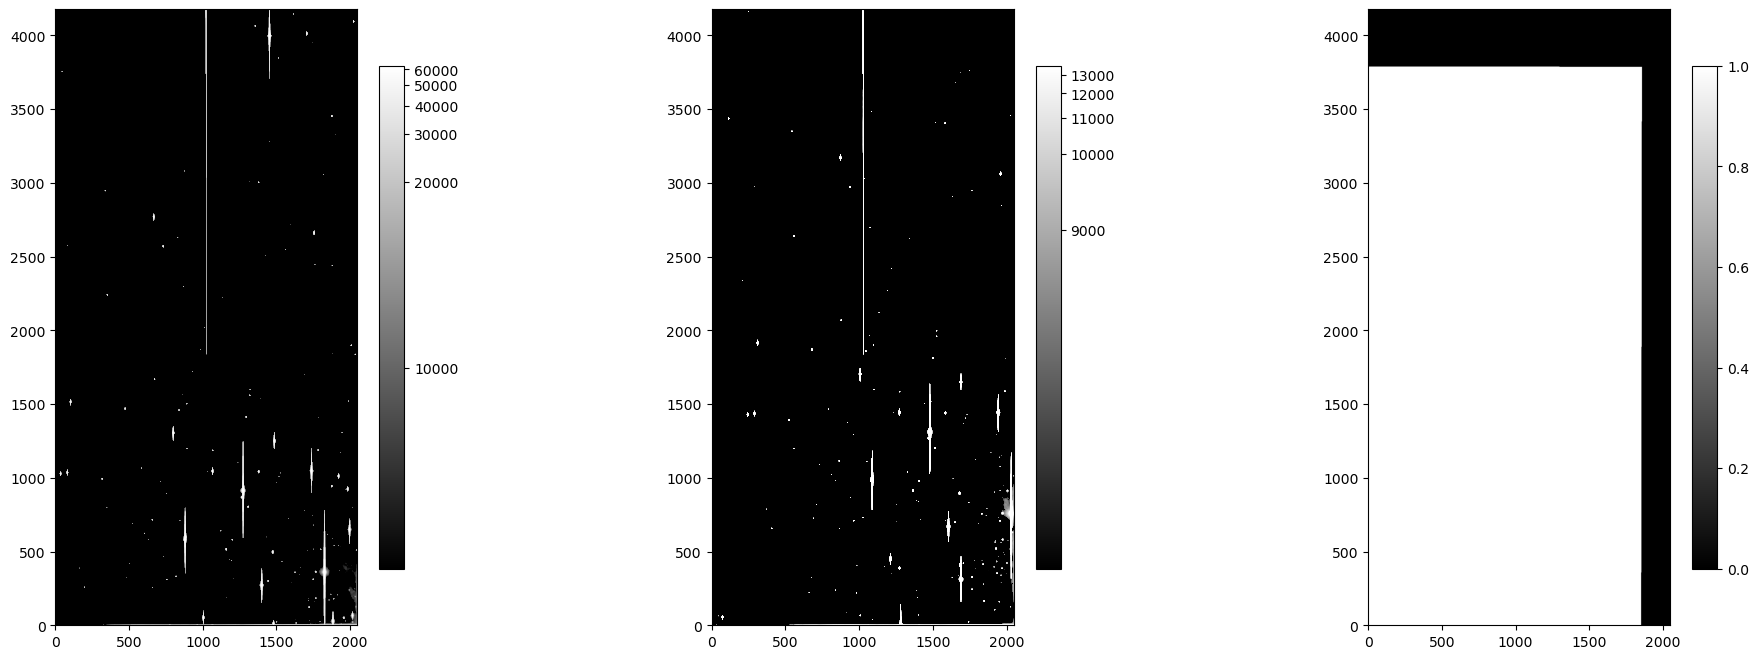

In [8]:
cmap = plt.get_cmap('gray').copy()
cmap.set_bad('red')
cmap.set_over('blue')
cmap.set_under('green')
fig, ax = plt.subplots(ncols=3,figsize=(24,8))
show_image(img_data,fig=fig, ax=ax[0], log=True, percu=99.9,cmap=cmap)
show_image(img_data1, fig=fig, ax=ax[1], log=True,percu=99.5,cmap=cmap)
show_image(registered_image, fig=fig, ax=ax[2], is_mask=True, cmap=cmap)

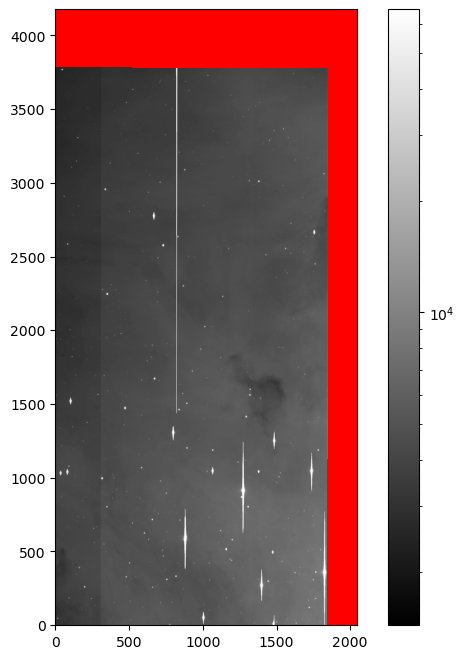

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
norm= colors.LogNorm()
pcm = ax.imshow(registered_image, origin='lower', norm=norm, cmap=cmap)
fig.colorbar(pcm)

In [10]:
registered_false, footprint = aa.register(false_data1, false_data, fill_value=np.nan)

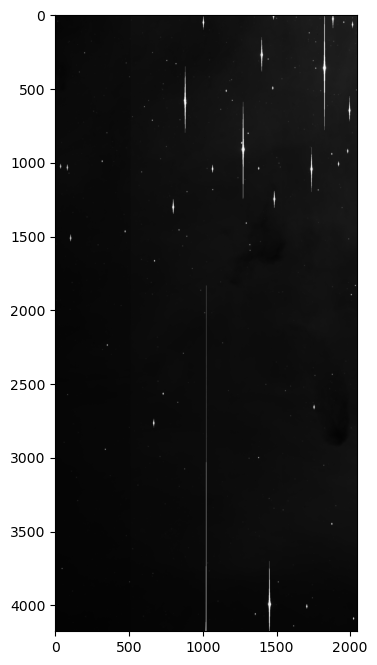

In [11]:
fig, ax = plt.subplots(ncols=1,figsize=(24,8))
ax.imshow(img_data,  cmap=cmap)

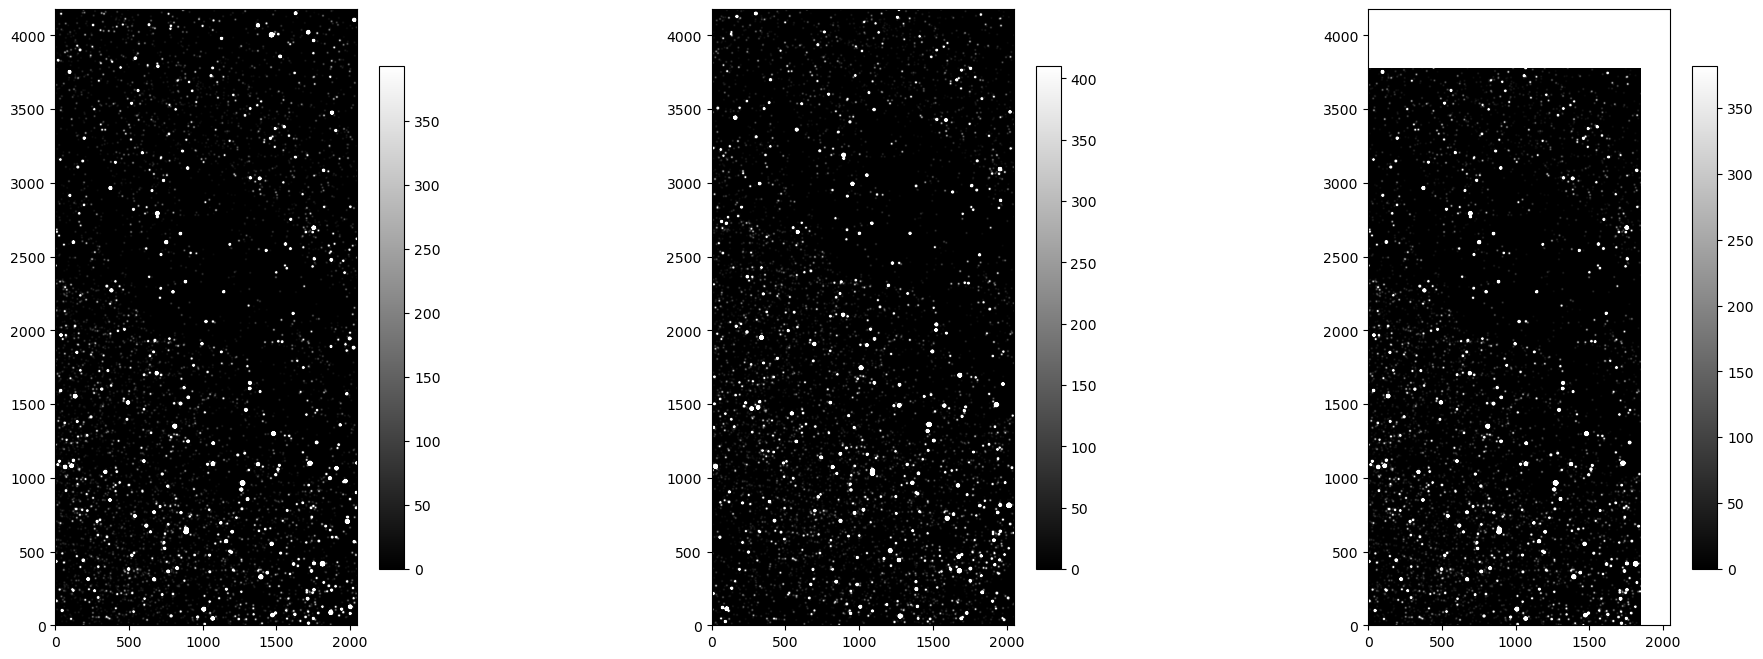

In [12]:
fig, ax = plt.subplots(ncols=3,figsize=(24,8))
show_image(false_data,fig=fig, ax=ax[0], cmap=cmap)
show_image(false_data1, fig=fig, ax=ax[1], cmap=cmap)
show_image(registered_false, fig=fig, ax=ax[2], cmap=cmap)

In [13]:
import ccdproc as ccdp
img_data_cr, mask = ccdp.cosmicray_lacosmic(img_data, sigclip=2)

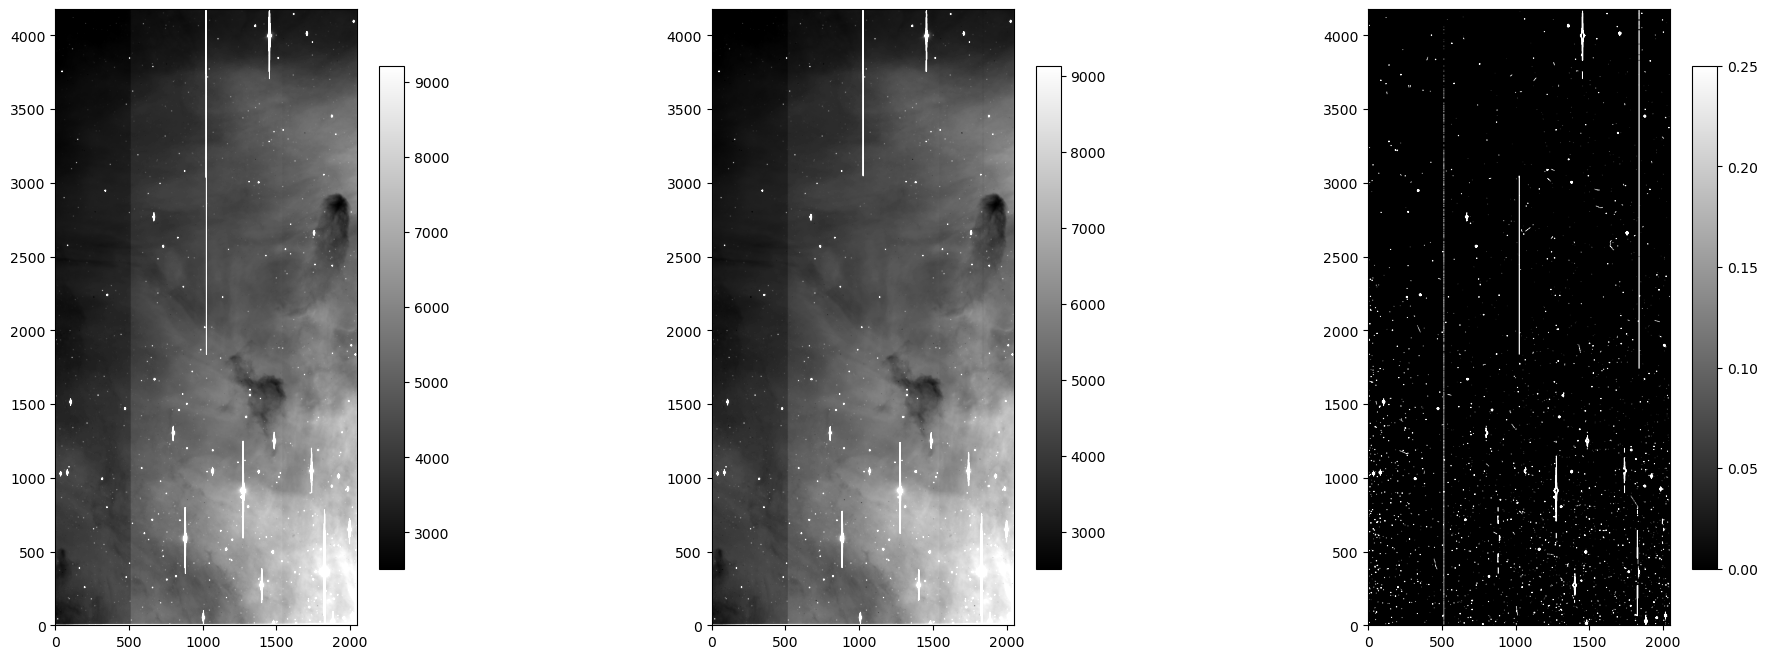

In [14]:
fig, ax = plt.subplots(ncols=3,figsize=(24,8))
show_image(img_data,fig=fig, ax=ax[0], cmap='gray')
show_image(img_data_cr, fig=fig, ax=ax[1], cmap='gray')
show_image(mask, fig=fig, ax=ax[2], cmap='gray')

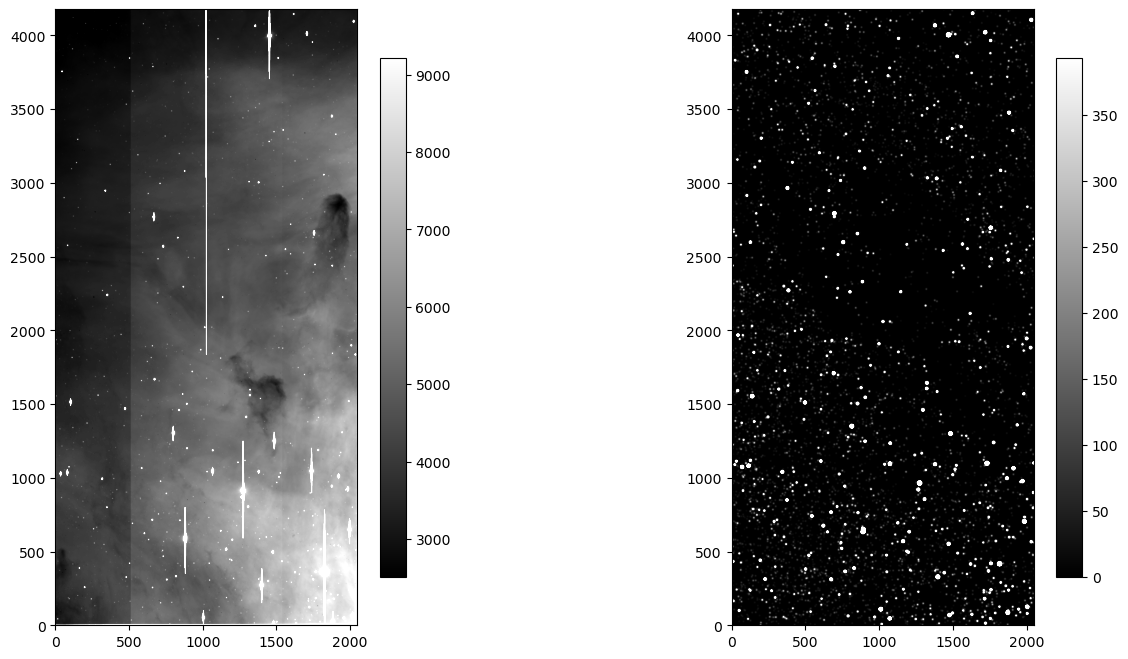

In [15]:
fig, ax = plt.subplots(ncols=2,figsize=(16,8))
show_image(img_data,fig=fig, ax=ax[0], cmap='gray')
show_image(false_data,fig=fig, ax=ax[1], cmap='gray')

In [16]:
false_data.dtype

dtype('<f4')

In [17]:
img_bkg = sep.Background(img_data)
false_bkg = sep.Background(false_data)

In [18]:
img_bkg.globalback, img_bkg.globalrms

(4534.38623046875, 72.12451934814453)

In [19]:
false_bkg.globalback, false_bkg.globalrms

(0.0, 0.004671967588365078)

In [20]:
bkg_img =img_bkg.back()
img_sub = img_data - bkg_img

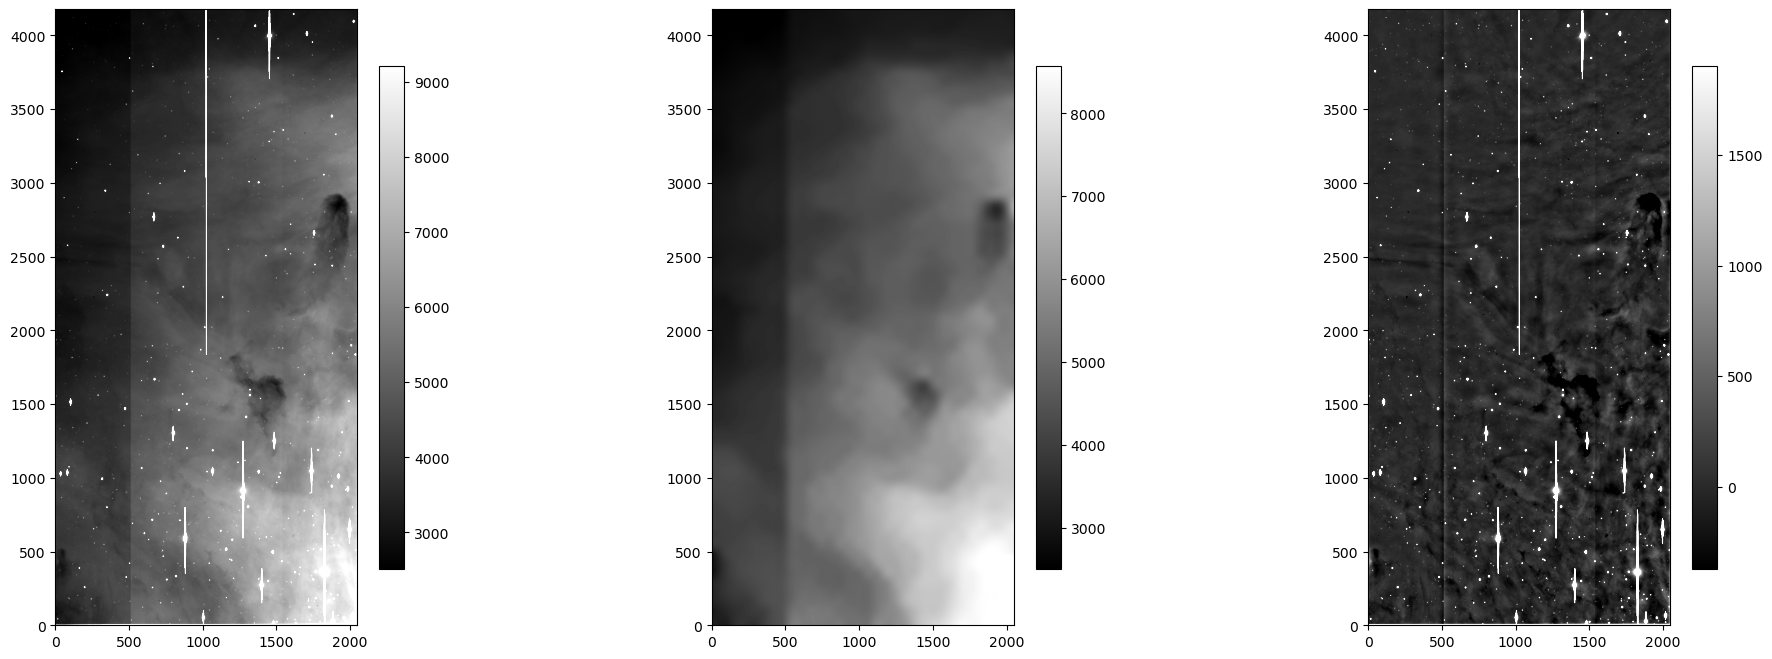

In [21]:
fig, ax = plt.subplots(ncols=3,figsize=(24,8))
show_image(img_data,fig=fig, ax=ax[0], cmap='gray')
show_image(bkg_img,fig=fig, ax=ax[1], cmap='gray')
show_image(img_sub,fig=fig, ax=ax[2], cmap='gray')

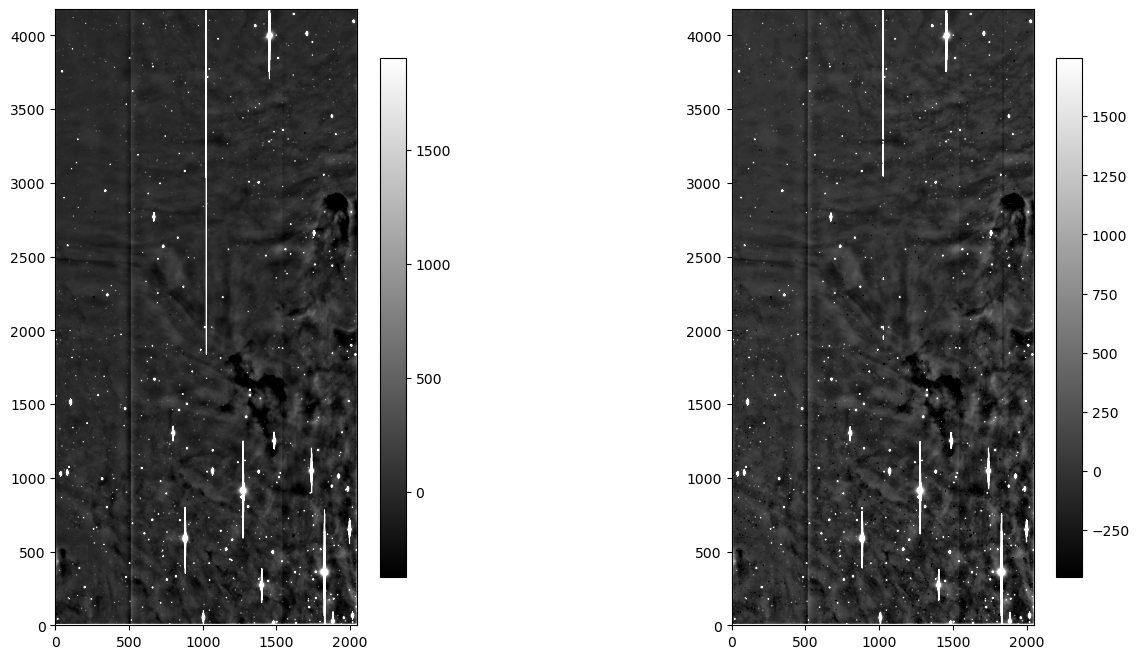

In [22]:
img_sub_cr, mask = ccdp.cosmicray_lacosmic(img_sub, satlevel=1200)
fig, ax = plt.subplots(ncols=2,figsize=(16,8))
show_image(img_sub,fig=fig, ax=ax[0], cmap='gray')
show_image(img_sub_cr, fig=fig, ax=ax[1], cmap='gray')

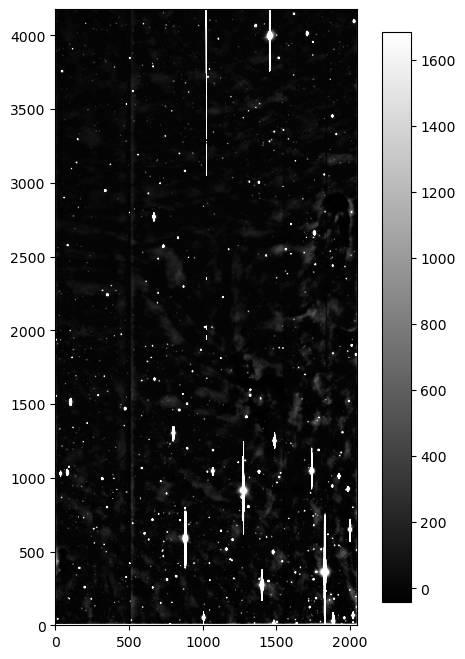

In [23]:
fig, ax = plt.subplots(ncols=1,figsize=(8,8))
show_image(img_sub_cr * ~mask,fig=fig, ax=ax, cmap='gray')

In [24]:
objects = sep.extract(img_sub, 150, err=img_bkg.globalrms)
len(objects)

128

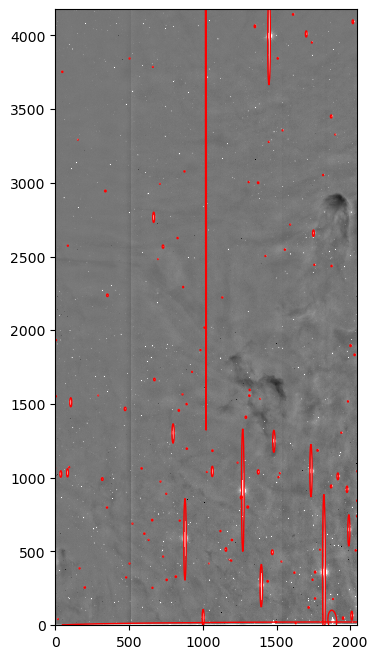

In [25]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
data_sub = img_sub
fig, ax = plt.subplots(figsize=(8,8))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [26]:
import pandas as pd

In [27]:
objects_df = pd.DataFrame(objects)
objects_df

thresh  npix  tnpix  xmin  xmax  ymin  ymax            x  \
0    10818.677734    18     18  1629  1632    12    16  1630.504727   
1    10818.677734    23     22  1495  1500    19    23  1497.426274   
2    10818.677734     9      9    17    19    40    42    18.027409   
3    10818.677734    74     62  1948  1955    42    54  1951.608438   
4    10818.677734   311    250  2005  2016    38    90  2010.626273   
..            ...   ...    ...   ...   ...   ...   ...          ...   
123  10818.677734    82     74  1350  1357  4055  4068  1353.380434   
124  10818.677734   121    103  2014  2022  4082  4101  2017.909608   
125  10818.677734    44     38  1610  1616  4138  4145  1612.721330   
126  10818.677734  8704   4159  1017  1023  1833  4176  1021.366805   
127  10818.677734  3919   3266  1438  1461  3702  4176  1449.111946   

               y        x2  ...       cxy         cflux          flux  \
0      13.754624  1.030972  ... -0.020794  3.359529e+05  3.695803e+05   
1      21.104555  1.685409  ... -0.237434  4.050534e+05  4.373585e+05   
2      41.002264  0.628171  ...  0.006458  1.193323e+05  1.365761e+05   
3      48.026646  2.736572  ... -0.003536  2.480967e+06  2.553698e+06   
4      64.472781  4.188812  ...  0.000514  1.170463e+07  1.200273e+07   
..           ...       ...  ...       ...           ...           ...   
123  4061.101626  2.839837  ...  0.012739  2.722568e+06  2.808488e+06   
124  4091.575083  3.264201  ... -0.000132  5.067299e+06  5.200105e+06   
125  4141.664699  2.253927  ...  0.002805  1.258186e+06  1.309363e+06   
126  3309.311806  1.200172  ...  0.001382  2.594626e+08  2.636018e+08   
127  3975.584078  8.976145  ... -0.000377  1.691092e+08  1.712473e+08   

            cpeak          peak  xcpeak  ycpeak  xpeak  ypeak  flag  
0    26162.378906  30905.568359    1631      14   1631     14     0  
1    26119.150391  30003.908203    1497      21   1497     21     0  
2    16196.324219  19466.009766      18      41     18     41     0  
3    53476.359375  53768.085938    1951      48   1951     47     0  
4    54947.542969  55111.976562    2009      64   2009     65     0  
..            ...           ...     ...     ...    ...    ...   ...  
123  55823.632812  56320.109375    1354    4060   1355   4060     0  
124  62367.468750  62370.253906    2018    4094   2018   4097     0  
125  55047.332031  56789.289062    1613    4142   1612   4142     0  
126  62490.566406  62490.656250    1020    4117   1019   4116     2  
127  60484.429688  60577.871094    1457    3995   1457   3996     2  

[128 rows x 30 columns]

In [28]:
objects_false = sep.extract(false_data, 250)
len(objects_false)


799

In [29]:
objects_df.columns

Index(['thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y',
       'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx',
       'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak',
       'xpeak', 'ypeak', 'flag'],
      dtype='object')

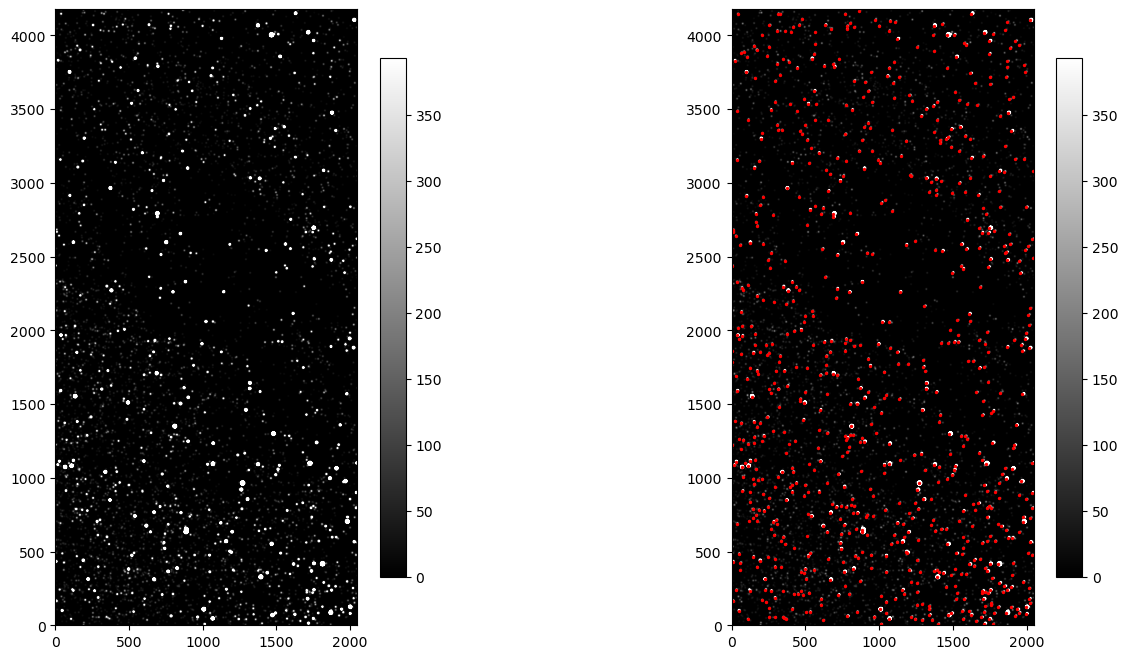

In [30]:
from matplotlib.patches import Ellipse


fig, axs = plt.subplots(figsize=(16,8),ncols=2)
show_image(false_data,fig=fig, ax=axs[0], cmap='gray')
# m, s = np.mean(data_sub), np.std(data_sub)
# im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
#                vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
show_image(false_data,fig=fig, ax=axs[1], cmap='gray')
axs[1].scatter(objects_false['xpeak'], objects_false['ypeak'],color='red',s=2)


In [31]:
registered_image, mask = aa.register(img_data, false_data, detection_sigma=100, max_control_points=150, fill_value=np.nan)

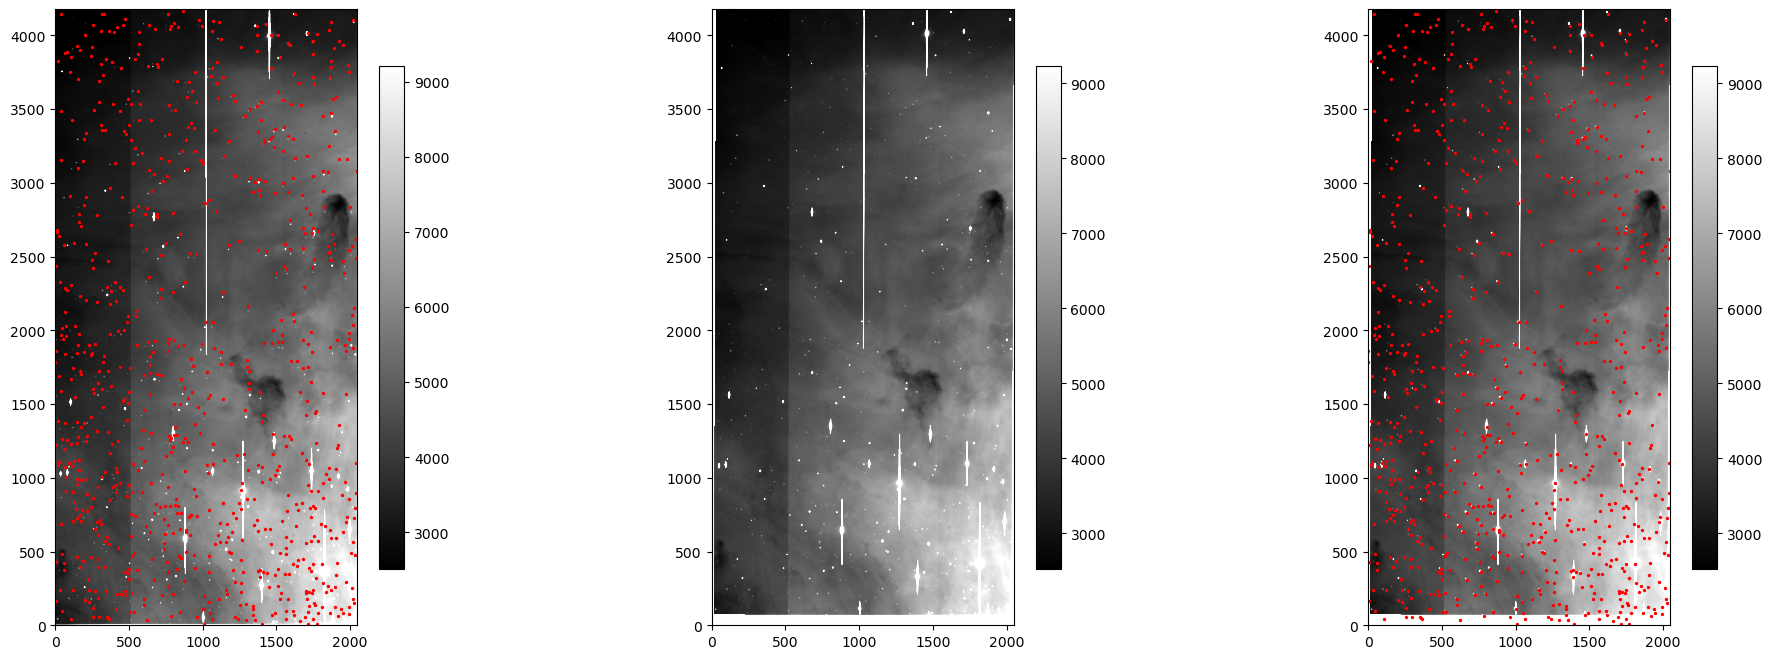

In [32]:
fig, axs = plt.subplots(figsize=(24,8),ncols=3)
show_image(img_data,fig=fig, ax=axs[0], cmap='gray')
axs[0].scatter(objects_false['x'], objects_false['y'],color='red',s=2)
# m, s = np.mean(data_sub), np.std(data_sub)
# im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
#                vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
show_image(registered_image,fig=fig, ax=axs[1], cmap=cmap)

show_image(registered_image,fig=fig, ax=axs[2], cmap='gray')
axs[2].scatter(objects_false['x'], objects_false['y'],color='red',s=2)

In [33]:
from astropy.wcs import WCS, FITSFixedWarning
img_wcs = WCS(img_hdr)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


In [56]:
img_wcs.pixel_to_world()

TypeError: WCS projection has 2 dimensions, so expected 2 (an Nx2 array and the origin argument) or 3 arguments (the position in each dimension, and the origin argument). Instead, 1 arguments were given.

In [34]:

import os
from utils import obs_dirs
from astropy.time import Time
from astropy.table import Table
dirs = obs_dirs('/home/kevin/Documents/M8data', 'M8')
detector = img_hdr['DETECTOR']
# detector = hdr['OBJECT']
xmatchpath = os.path.join(dirs['xmatch_tables'], detector+'_xmatch.xml')
#xmatchpath = os.path.join(dirs['xmatch_tables'], detector)
xmatch_tbl_all = Table.read(xmatchpath)
xmatch_tbl = xmatch_tbl_all[xmatch_tbl_all['phot_g_mean_mag']<=15]
len(xmatch_tbl_all),len(xmatch_tbl)

(17861, 291)

In [35]:
from astropy.coordinates import SkyCoord
import astropy.units as u
t_obs = Time(img_hdr['MJD'], scale='utc', format='mjd')
#hard code for gaia dr3:
t_gaia = Time(2016, scale='tcb',format='jyear')

coords_gaia = SkyCoord(ra = xmatch_tbl['ra']*u.degree, dec = xmatch_tbl['dec']*u.degree,
                pm_ra_cosdec = xmatch_tbl['pmra'].filled(fill_value=0.0)*u.mas/u.year,
                pm_dec = xmatch_tbl['pmdec'].filled(fill_value=0.0)*u.mas/u.year,
                radial_velocity = xmatch_tbl['radial_velocity'].filled(fill_value=0.0)*u.km/u.second,
                distance = 1000.0/np.abs(xmatch_tbl['parallax']) * u.pc,
                obstime = t_gaia)
coords = coords_gaia.apply_space_motion(new_obstime=t_obs).fk5

In [36]:

in_image = img_wcs.footprint_contains(coords)
gaia_pixels = img_wcs.world_to_array_index(coords[in_image])

In [37]:
len(coords),len(gaia_pixels[0])

(291, 97)

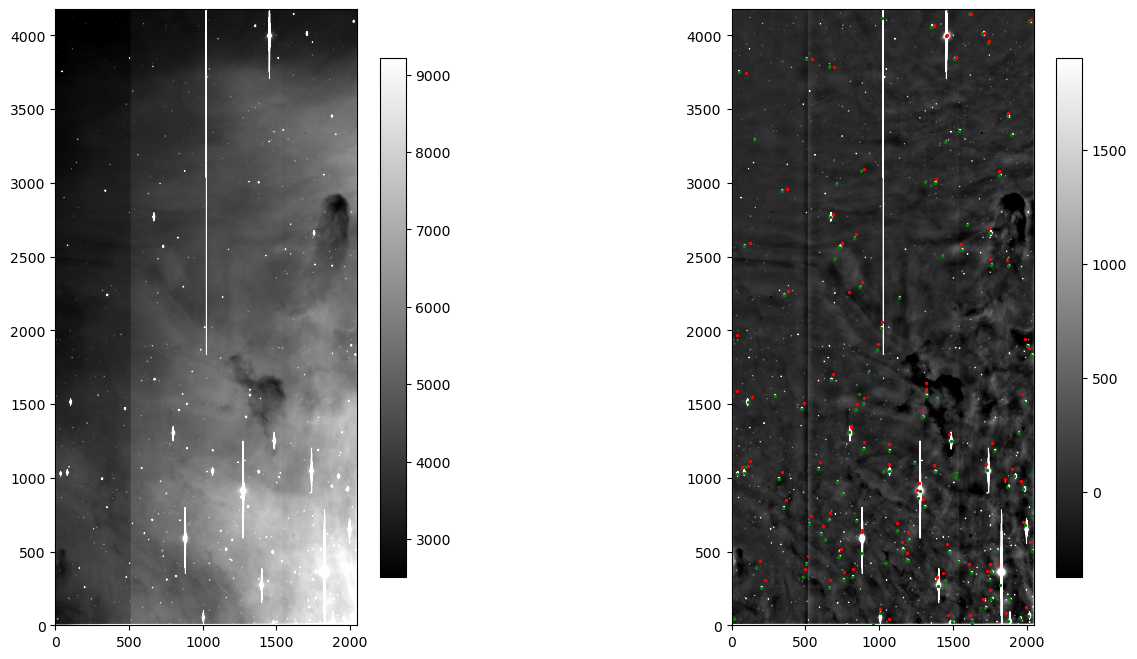

In [38]:
data_sub = img_sub
fig, axs = plt.subplots(figsize=(16,8),ncols=2)
show_image(img_data,fig=fig, ax=axs[0], cmap='gray')
# m, s = np.mean(data_sub), np.std(data_sub)
# im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
#                vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
show_image(data_sub,fig=fig, ax=axs[1], cmap='gray')
axs[1].scatter(objects['xpeak'], objects['ypeak'],color='green',s=2)
axs[1].scatter(gaia_pixels[1],gaia_pixels[0], color='red',s=2)

In [39]:
def find_nearest(obj, gaiapx):
    """
    finds nearest gaia object to obj
    """
    gpx = np.array([gaiapx[1],gaiapx[0]])
    offsets = gpx - np.array([obj['x'],obj['y']]).reshape(-1,1)
    dist =np.sqrt((offsets**2).sum(axis=0))
    min_i = dist.argmin()
    return min_i, dist[min_i]


In [40]:
gaia_nearest = np.array([find_nearest(o, gaia_pixels) for o in objects])

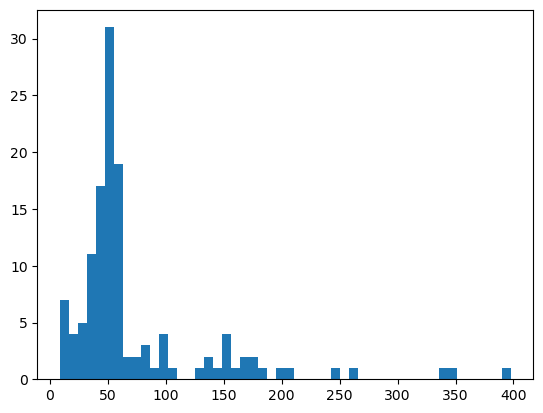

In [41]:
zz=plt.hist(gaia_nearest[:,1],bins=50)

In [176]:
pctile=np.percentile(gaia_nearest[:,1], [25, 75])
pctile

array([41.04114607, 69.68911518])

In [42]:
pctile=np.percentile(gaia_nearest[:,1], [25, 75])
src=np.array([[o['xpeak'],o['ypeak'] ] for o in objects])
gpx = np.array([gaia_pixels[1],gaia_pixels[0]]).T
dst = gpx[gaia_nearest[:,0].astype(int)]
mid_dist = np.logical_and(gaia_nearest[:,1]>pctile[0],gaia_nearest[:,1]<pctile[1])
src=src[mid_dist]
dst = dst[mid_dist]

In [43]:
tform = aa.estimate_transform('affine', src, dst)
#swap src & dest to get the inverse transform
# tform_inv = aa.estimate_transform('polynomial',  dst, src)
# tform.inverse = tform_inv

In [44]:
tform.params

array([[9.75690057e-01, 6.04830754e-03, 2.48949276e+01],
       [4.14594265e-03, 9.86897021e-01, 5.28088096e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [45]:
from skimage import transform

In [47]:
transform.matrix_transform(src, tform.params)

array([[1616.33008644,   73.38740035],
       [1485.629957  ,   79.74012318],
       [1985.44939156,  125.28631474],
       [1004.02616067,  140.85343686],
       [1701.85624198,  178.35918159],
       [1745.15555123,  238.74232134],
       [ 669.41094513,  306.21282913],
       [ 222.55699578,  306.28778144],
       [1432.66669501,  352.87842521],
       [ 763.40379919,  359.90327876],
       [1729.34300363,  364.994659  ],
       [ 496.16754488,  375.54453983],
       [ 824.02964547,  381.87206166],
       [1609.61739711,  410.86886804],
       [1394.43938188,  324.09671983],
       [ 187.24274366,  434.43099429],
       [1191.542324  ,  490.01581437],
       [1179.87638148,  496.8743422 ],
       [ 740.94287042,  515.73350545],
       [1466.05598347,  547.43395445],
       [2015.44206508,  561.61088441],
       [1197.26753734,  628.20212702],
       [ 617.96772088,  668.17600899],
       [1121.52661137,  687.09256475],
       [ 539.3481112 ,  734.94918506],
       [ 670.23573818,  7

In [182]:
registered_image, footprint = aa.apply_transform(tform, img_data, img_data, fill_value=np.nan)

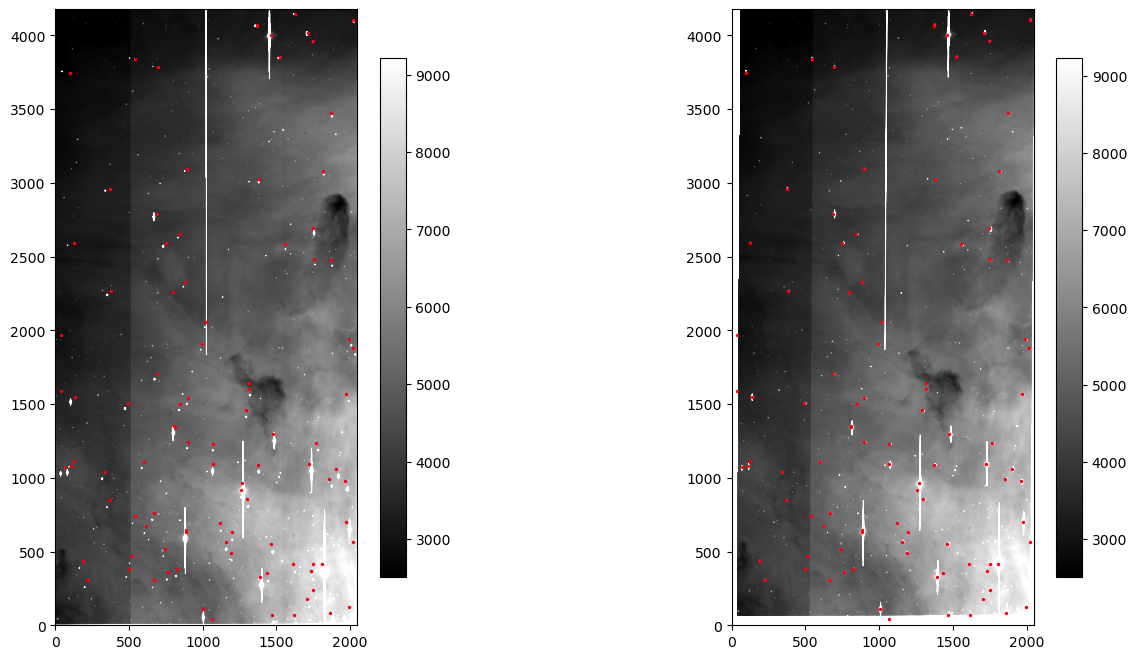

In [183]:
fig, axs = plt.subplots(figsize=(16,8),ncols=2)
show_image(img_data,fig=fig, ax=axs[0], cmap='gray')
axs[0].scatter(gaia_pixels[1],gaia_pixels[0], color='red',s=2)
# m, s = np.mean(data_sub), np.std(data_sub)
# im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
#                vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
show_image(registered_image,fig=fig, ax=axs[1], cmap='gray')
# axs[1].scatter(objects['x'], objects['y'],color='red',s=2)
axs[1].scatter(gaia_pixels[1],gaia_pixels[0], color='red',s=2)

In [185]:
registered_image = np.ma.masked_array(registered_image, mask = np.isnan(registered_image)).filled(fill_value = -32768).astype(np.int32)

In [190]:
img_wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               5268.0 / Pixel coordinate of reference point            
CRPIX2  =                -23.0 / Pixel coordinate of reference point            
PC1_1   =           -5.611E-05 / Coordinate transformation matrix element       
PC2_2   =            5.611E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =            270.90375 / [deg] Coordinate value at reference point      
CRVAL2  =         -24.386652

In [191]:
phdu = fits.PrimaryHDU(data = registered_image, header=img_wcs.to_header())

In [192]:
phdu.writeto('../data/registered.fits', overwrite=True)

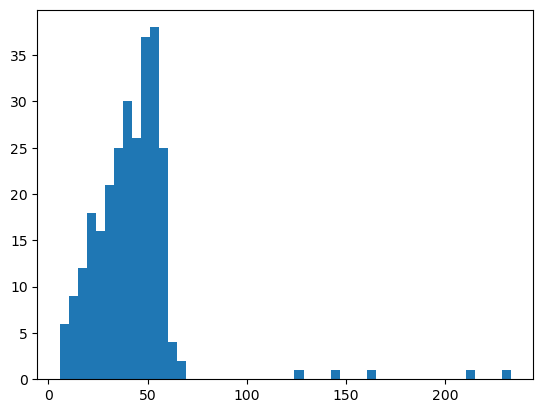

In [77]:
zz=plt.hist(gaia_nearest[:,1],bins=50)

In [ ]:
# from astropy.wcs import WCS

# wcs = WCS(false_hdr)


In [ ]:
mask = img_data==-32768
print(f'Number of masked values: {mask.sum()}')
bkg = sep.Background(img_data, mask=mask,  bw=64, bh=64, fw=3, fh=3)

In [ ]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

In [ ]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

In [ ]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [ ]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

In [ ]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [ ]:
# subtract the background
data_sub = img_data - bkg

In [ ]:
data_sub.min()

In [ ]:
objects = sep.extract(data_sub,  500, mask=mask, err=bkg.globalrms)
len(objects)

In [ ]:
objects[0]

In [ ]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, axs = plt.subplots(ncols=2, figsize=(18,9))
img_data_masked = np.ma.masked_array(img_data, mask=mask)
m, s = np.mean(img_data_masked), np.std(img_data_masked)
ax=axs[0]
im = ax.imshow(img_data_masked, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+3*s, origin='lower')
ax=axs[1]
im = ax.imshow(img_data_masked, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+3*s, origin='lower')
npix = objects['npix']
which_obj = np.logical_and(npix>0, npix <=50)
which_obj = np.logical_and(which_obj, objects['flux']> 1e6)
ax.scatter(objects['x'][which_obj], objects['y'][which_obj], color='red',s=2)
# plot an ellipse for each object
# for i in range(len(objects)):
#     if npix[i] <400 or npix[i] > 500:
#         continue
#     e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
#                 width=6*objects['a'][i],
#                 height=6*objects['b'][i],
#                 angle=objects['theta'][i] * 180. / np.pi)
#     e.set_facecolor('none')
#     e.set_edgecolor('red')
#     ax.add_artist(e)

In [ ]:
zz=plt.hist(objects['flux'][which_obj], bins=50)


In [ ]:
objects['flux'].min(), objects['flux'].max(), np.median(objects['flux'])

In [ ]:
(objects['flux'] >= 10e6).sum()

In [ ]:
zz=plt.hist(objects['npix'], bins=50, range=(0,200))
plt.xlim(0,1000)

In [ ]:
img_clipped = np.where(img_data > 3000, img_data, 0.001)
registered_image, footprint = aa.register(img_clipped, false_data, fill_value=np.nan)

In [ ]:
import matplotlib as mpl


wcs = WCS(false_hdr)

In [ ]:
cmap = mpl.cm.binary_r.copy()
cmap.set_bad(color='blue')

vmin=100; vmax=1500
fig = plt.figure(figsize=(24,8))
ax3 = plt.subplot(131, projection=wcs)
#img_clipped = np.clip(img_data,np.percentile(img_data, 0.5), np.percentile(img_data,99.5))
img_clipped = np.where(img_data > 5000, img_data, 0.001)
ax3.imshow(img_clipped,   origin='lower', cmap=cmap, norm=colors.LogNorm())#a_min=vmin, a_max=vmax,
ax3.set_title('Image to be Registered')

ax1 = plt.subplot(132, projection=wcs)
false_clipped = np.clip(false_data,a_min=vmin, a_max= vmax)
ax1.imshow(false_clipped,  origin='lower', cmap=cmap, norm=colors.LogNorm())
ax1.set_title('False Image')

# ax2 = plt.subplot(133, projection=wcs)
# reg_clipped = np.clip(registered_image,np.nanpercentile(registered_image, 0.5), np.nanpercentile(registered_image,99.5))


# ax2.imshow(reg_clipped,   origin='lower', cmap=cmap, norm=colors.LogNorm())
# ax2.set_title('Registered Image')



fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax2 = plt.subplot(111, projection=wcs)
img_clipped = np.where(img_data > 3000, img_data, 0.001)


ax2.imshow(img_clipped,   origin='lower', cmap=cmap, norm=colors.LogNorm())
ax2.set_title('clipped Image')

In [ ]:
np.percentile(registered_image, 1.0), np.percentile(registered_image,99)

In [ ]:
footprint.sum(), np.isnan(registered_image).sum()

In [ ]:
np.nanmin(registered_image), np.nanmax(registered_image)


In [ ]:
np.nanmin(img_data), np.nanmax(img_data)

In [ ]:
img_data.dtype

In [ ]:
new_hdr = wcs.to_header()
phdu = fits.PrimaryHDU(data = registered_image, header=new_hdr)
phdu.writeto('../data/registered_image.fits', overwrite=True)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax3 = plt.subplot(111, projection=wcs)
ax3.imshow(footprint,  origin='lower', cmap='Reds')
ax3.set_title('Footprint')

## Align overscan subracted images?

In [ ]:
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\no_bias\SUPA01564801.fits') as f:
    img1_hdr = f[0].header.copy()
    wcs = WCS(img1_hdr)
    img1_data = f[0].data.copy()
    #take out the overscan
    img1_data = remove_oscan(img1_hdr, img1_data)
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\no_bias\SUPA01564811.fits') as f:
    img11_hdr = f[0].header.copy()
    img11_data = f[0].data.copy()
    img11_data = remove_oscan(img11_hdr, img11_data)
    
#img1_data = img1_data.byteswap(inplace=True).newbyteorder()
#false1_data = false1_data.byteswap(inplace=True).newbyteorder()

In [ ]:
registered_image, footprint = aa.register(img11_data, img1_data, fill_value = np.nan)

In [ ]:
vmin=1000; vmax=25000
fig = plt.figure(figsize=(24,8))
ax1 = plt.subplot(131, projection=wcs)
ax1.imshow(img11_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax1.set_title('Image to be Registered')

ax2 = plt.subplot(133, projection=wcs)
ax2.imshow(registered_image,   origin='lower', cmap='binary_r', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax2.set_title('Registered Image')

ax3 = plt.subplot(132, projection=wcs)
ax3.imshow(img1_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax3.set_title('Target of Registration')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection=wcs)
ax1.imshow(footprint,  origin='lower', cmap='binary_r')

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(121,projection=wcs)
ax.imshow(img_data, origin='lower', cmap='gray', norm=colors.LogNorm(vmin=500, vmax=30000))
ax = plt.subplot(122,projection=wcs)
ax.imshow(img1_data, origin='lower', cmap='gray', norm=colors.LogNorm(vmin=500, vmax=30000))

In [ ]:
img_registered, footprint = aa.register(img1_data, img_data)

In [ ]:
fig = plt.figure(figsize=(24,8))
ax1 = plt.subplot(131, projection=wcs)
ax1.imshow(img_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm())
ax2 = plt.subplot(132, projection=wcs)
ax2.imshow(img_registered,  origin='lower', cmap='binary_r', norm=colors.LogNorm())
ax3 = plt.subplot(133, projection=wcs)
ax3.imshow(img1_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm())

In [ ]:
registered_image, footprint = aa.register(img_data, false_data)

[Subprime Data Reduction Guide](https://www.subarutelescope.org/Observing/Instruments/SCam/sdfred/sdfred2.html.en)
